# Анализ трендовой составляющей с помощью статистических методов

Окей, давайте загрузим датасет ``topics_over_time`` из ``4_visialisation.ipynb`` и проведем анализ трендовой компоненты

In [11]:
import pandas as pd

df = pd.read_csv('data/topics_over_time.csv')
df

,Topic,Words,Frequency,Timestamp,Name
0,-1,"action, scene, camera",120,2023-12-31 15:14:24,-1_scene_action_camera
1,0,"segmentation, medical, tumor",79,2023-12-31 15:14:24,0_segmentation_medical_mri
2,1,"i2v, editing, subject",24,2023-12-31 15:14:24,1_editing_edit_t2v
3,2,"robot, policy, manipulation",15,2023-12-31 15:14:24,2_robot_policy_manipulation
4,3,"facial, expression, identity",16,2023-12-31 15:14:24,3_facial_head_talk
...,...,...,...,...,...
408,29,"communication, ran, transmission",5,2024-11-30 14:00:00,29_communication_wireless_transmission
409,30,"game, ugc, textsc",4,2024-11-30 14:00:00,30_game_player_llm
410,31,"pulsar, velocity, kick",4,2024-11-30 14:00:00,31_pulsar_star_gravitational
411,32,"estimation, conformal, uncertainty",4,2024-11-30 14:00:00,32_estimation_occlusion_camera


Выберем интересующие нас темы из ``4_visialisation.ipynb``

In [12]:
df = df[df['Topic'].isin([1, 2, 3, 4, 5])]
df.sample(5, random_state=1547)

,Topic,Words,Frequency,Timestamp,Name
139,1,"editing, edit, dit",52,2024-05-01 16:00:00,1_editing_edit_t2v
312,2,"robot, policy, manipulation",69,2024-09-30 18:00:00,2_robot_policy_manipulation
349,5,"deepfake, attack, hindi",15,2024-10-31 04:00:00,5_deepfake_attack_adversarial
174,1,"editing, t2v, edit",54,2024-06-01 02:00:00,1_editing_edit_t2v
314,4,"scene, gaussian, splatting",16,2024-09-30 18:00:00,4_gaussian_scene_splatting


In [13]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns

df = df.copy()

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

df.loc[:, 'month'] = df['Timestamp'].dt.to_period('M').astype(str)

df_agg = df.groupby(['month', 'Name'])['Frequency'].sum().reset_index()

df_pivot = df_agg.pivot(index='month', columns='Name', values='Frequency').fillna(0)

df_pivot.index = pd.to_datetime(df_pivot.index)
df_pivot.loc[:, 'month_num'] = df_pivot.index.month

df_pivot


Name,1_editing_edit_t2v,2_robot_policy_manipulation,3_facial_head_talk,4_gaussian_scene_splatting,5_deepfake_attack_adversarial,month_num
month,,,,,,
2023-12-01,24,15,16,10,6,12
2024-01-01,23,30,15,7,16,1
2024-03-01,51,46,23,29,16,3
2024-04-01,18,14,19,14,13,4
2024-05-01,52,30,16,18,14,5
2024-06-01,54,35,12,22,16,6
2024-07-01,56,50,27,26,28,7
2024-08-01,26,52,25,15,16,8
2024-09-01,51,69,13,16,17,9


In [14]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

models = []
for topic in df.Name.unique():
    X = df_pivot['month_num']
    y = df_pivot[topic]
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    models.append(model)

stargazer = Stargazer(models)

stargazer.title("Regression results by topics (with HAC robust errors)")
stargazer.custom_columns(list(df.Name.unique()), [1]*5)

stargazer

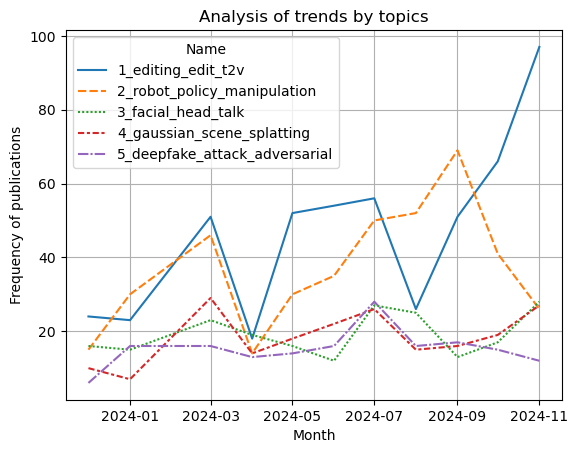

In [15]:
sns.lineplot(data=df_pivot.drop('month_num', axis=1))
plt.xlabel('Month')
plt.ylabel('Frequency of publications')
plt.grid()
plt.title('Analysis of trends by topics')
plt.show()

# Анализ с данными за 2025 год

Давайте проверим тренд добавив 2025 год и сделаем ту же предобработку, что и в блоке 3

In [16]:
import pandas as pd
import re
import torch
from numba import cuda
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import bertopic
from sklearn.feature_extraction.text import CountVectorizer
from cuml.cluster import HDBSCAN
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
import os
from pandarallel import pandarallel
import spacy
from utils import check_gpu
import random

random.seed(42)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

tqdm.pandas()
check_gpu()

Доступно GPU: 1
Название GPU: NVIDIA GeForce RTX 4070 Ti SUPER


In [17]:
df_full = pd.read_csv('data/arxiv_video_generation_papers_2024_2025.csv')
df_full.sample(2, random_state=1547)

,entry_id,arxiv_id,title,authors,abstract,published,updated,year,categories,primary_category,pdf_url,arxiv_url,doi,comment,journal_ref
7790,http://arxiv.org/abs/2410.20062v1,2410.20062v1,Transforming Precision: A Comparative Analysis...,"Tasnim Sakib Apon, Md. Fahim-Ul-Islam, Nafiz I...",Knee osteoarthritis(KO) is a degenerative join...,2024-10-26,2024-10-26,2024,"eess.IV, cs.AI, cs.CV",eess.IV,http://arxiv.org/pdf/2410.20062v1,http://arxiv.org/abs/2410.20062v1,NaN,NaN,NaN
7919,http://arxiv.org/abs/2503.08609v1,2503.08609v1,Vision Transformer for Intracranial Hemorrhage...,"Mehdi Hosseini Chagahi, Niloufar Delfan, Behza...",Intracranial hemorrhage (ICH) is a critical me...,2025-03-11,2025-03-11,2025,"eess.IV, cs.AI, cs.CV",eess.IV,http://arxiv.org/pdf/2503.08609v1,http://arxiv.org/abs/2503.08609v1,NaN,NaN,NaN


In [18]:
pandarallel.initialize(nb_workers=8, progress_bar=True)

df_full['abstract'] = df_full['abstract'].parallel_apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [19]:
df_full['title_abstract'] = df_full['title'] + ' ' + df_full['abstract']

In [20]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(df_full.title_abstract.to_list(), show_progress_bar=True, batch_size=64)

Batches:   0%|          | 0/139 [00:00<?, ?it/s]

In [21]:
def lemmatize(text):
    if not hasattr(lemmatize, "nlp"):
        lemmatize.nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
        
    doc = lemmatize.nlp(text)
    return " ".join(token.lemma_ for token in doc if not token.is_punct and not token.is_space)

pandarallel.initialize(nb_workers=8, progress_bar=True)

df_full['title_abstract_lem'] = df_full['title_abstract'].parallel_apply(lemmatize)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [22]:
bertopic_model = bertopic.BERTopic.load("bertopic_model", embedding_model=embedding_model)

In [23]:
new_topics, new_probs = bertopic_model.transform(df_full.title_abstract_lem.to_list(), embeddings=embeddings)

documents = df_full.title_abstract_lem.to_list()
timestamps = pd.to_datetime(df_full.published).to_list()
new_topics = list(new_topics)


topics_over_time = bertopic_model.topics_over_time(documents, timestamps, topics=new_topics, nr_bins=15)
topic_info = bertopic_model.get_topic_info()[['Topic', 'Name']]
topics_over_time = topics_over_time.merge(topic_info, on='Topic', how='left')
topics_over_time

2025-04-02 08:24:56,287 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.
15it [00:01, 14.49it/s]


,Topic,Words,Frequency,Timestamp,Name
0,-1,"id, deblurring, morph",16,2023-12-31 13:10:33.600,-1_scene_action_camera
1,0,"segmentation, medical, tumor",78,2023-12-31 13:10:33.600,0_segmentation_medical_mri
2,1,"style, i2v, editing",24,2023-12-31 13:10:33.600,1_editing_edit_t2v
3,2,"robot, policy, manipulation",17,2023-12-31 13:10:33.600,2_robot_policy_manipulation
4,3,"facial, expression, identity",12,2023-12-31 13:10:33.600,3_facial_head_talk
...,...,...,...,...,...
520,29,"channel, communication, transmission",5,2025-02-24 22:24:00.000,29_communication_wireless_transmission
521,30,"game, player, scam",9,2025-02-24 22:24:00.000,30_game_player_llm
522,31,"temperature, gravitational, hole",5,2025-02-24 22:24:00.000,31_pulsar_star_gravitational
523,32,"estimation, expressivity, trajectory",10,2025-02-24 22:24:00.000,32_estimation_occlusion_camera


In [24]:
topics_over_time = topics_over_time[topics_over_time['Topic'].isin([1, 2, 3, 4, 5])]
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
2,1,"style, i2v, editing",24,2023-12-31 13:10:33.600,1_editing_edit_t2v
3,2,"robot, policy, manipulation",17,2023-12-31 13:10:33.600,2_robot_policy_manipulation
4,3,"facial, expression, identity",12,2023-12-31 13:10:33.600,3_facial_head_talk
5,4,"scene, gaussian, rendering",15,2023-12-31 13:10:33.600,4_gaussian_scene_splatting
6,5,"attack, forgery, deepfake",12,2023-12-31 13:10:33.600,5_deepfake_attack_adversarial
...,...,...,...,...,...
492,1,"editing, edit, sampling",96,2025-02-24 22:24:00.000,1_editing_edit_t2v
493,2,"robot, policy, robotic",59,2025-02-24 22:24:00.000,2_robot_policy_manipulation
494,3,"portrait, facial, head",30,2025-02-24 22:24:00.000,3_facial_head_talk
495,4,"gaussian, scene, splatting",56,2025-02-24 22:24:00.000,4_gaussian_scene_splatting


In [25]:
df = topics_over_time.copy()

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

df.loc[:, 'month'] = df['Timestamp'].dt.to_period('M').astype(str)

df_agg = df.groupby(['month', 'Name'])['Frequency'].sum().reset_index()

df_pivot = df_agg.pivot(index='month', columns='Name', values='Frequency').fillna(0)

df_pivot.index = pd.to_datetime(df_pivot.index)
df_pivot.loc[:, 'month_num'] = df_pivot.index.month

df_pivot


Name,1_editing_edit_t2v,2_robot_policy_manipulation,3_facial_head_talk,4_gaussian_scene_splatting,5_deepfake_attack_adversarial,month_num
month,,,,,,
2023-12-01,24,17,12,15,12,12
2024-01-01,25,32,16,12,18,1
2024-03-01,80,59,37,68,33,3
2024-04-01,43,25,17,25,17,4
2024-05-01,58,31,17,36,22,5
2024-06-01,34,27,19,21,16,6
2024-07-01,29,17,15,13,17,7
2024-08-01,25,43,23,26,17,8
2024-09-01,44,61,11,25,19,9


In [31]:
import statsmodels.api as sm
from stargazer.stargazer import Stargazer


models = []
for topic in df.Name.unique():
    X = df_pivot['month_num']
    y = df_pivot[topic]
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    models.append(model)

stargazer = Stargazer(models)

stargazer.title("Regression results by topics (with HAC robust errors)")
stargazer.custom_columns(list(df.Name.unique()), [1]*5)

stargazer

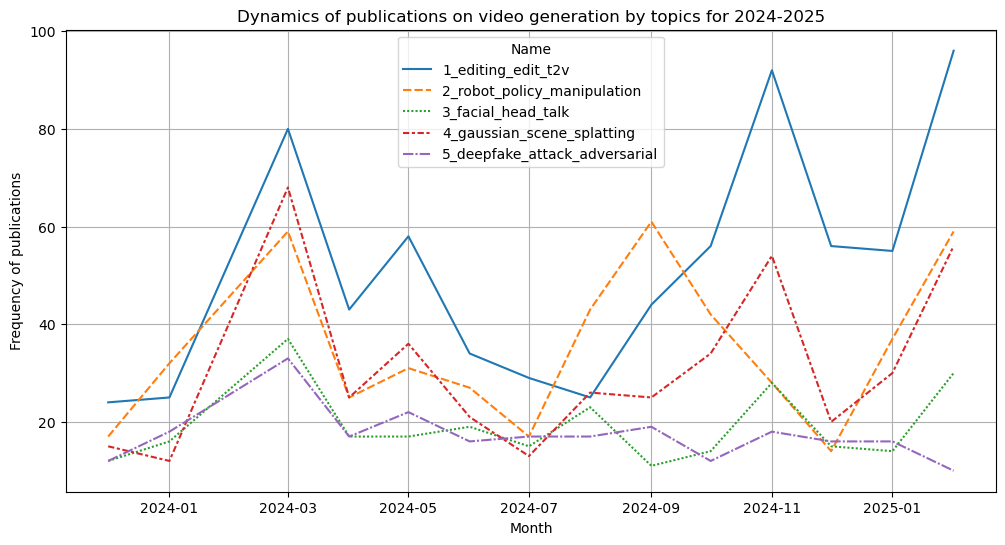

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pivot.drop('month_num', axis=1))
plt.xlabel('Month')
plt.ylabel('Frequency of publications')
plt.grid()
plt.title('Dynamics of publications on video generation by topics for 2024-2025')
plt.show()